In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

# Import and Clean Data

In [2]:
def get_data_with_dummies(yvar,clustervar):

    # Import data
    df = pd.read_stata("./smith_code/replication_dataset_main.dta")
    df['_const'] = 1

    # Make region dummies
    df = df[df.region != '']
    for i,region in enumerate(np.sort(df.region.unique())):
        if (i != 0):
            df[f"_Iregion_{i+1}"] = np.where(df.region == region, 1, 0)
    region_dummies = [col for col in df if col.startswith('_Iregion_')]

    # Make year dummies - omit 1950 (and also 2009,2010 due to collinearity)
    for i,year in enumerate(np.sort(df.year.unique())):
        if (i != 0) & (year != 2009) & (year != 2010):
            df[f"_Iyear_{year}"] = np.where(df.year == year, 1, 0)
    year_dummies = [col for col in df if col.startswith('_Iyear_')]

    # Make region-year interaction dummies
    for i,region in enumerate(np.sort(df.region.unique())):
        for j,year in enumerate(np.sort(df.year.unique())):
            if (f"_Iyear_{year}" in year_dummies) & (f"_Iregion_{i+1}" in region_dummies):
                df[f"_IregXyea_{i+1}_{year}"] = np.where((df.year == year) & (df.region == region), 1, 0)
    regionXyear_dummies = [col for col in df if col.startswith('_IregXyea_')]
    
    # Drop with missing yvariables
    df = df[~df[yvar].isna()]
    df[clustervar] = df[clustervar].astype('string')
    
    return df,region_dummies,year_dummies,regionXyear_dummies

In [3]:
# Import main data
yvar       = 'lnGDPpc_Madd'
clustervar = 'countrycode'
df,region_dummies,year_dummies,regionXyear_dummies = get_data_with_dummies(yvar,clustervar)

# Q1(a) - Replication of DiD and Event Study

## Helper Functions

In [4]:
def run_regression(df,yvar,xvars,clustervar,return_R2):
    
    regdf = df.copy()
    
    # De-mean by cluster 
    grouped_df = regdf.groupby(clustervar)
    for xvar in xvars:
        if xvar != "_const":
            regdf[xvar] = regdf[xvar]-grouped_df[xvar].transform('mean')   
    regdf[yvar] = regdf[yvar]-grouped_df[yvar].transform('mean')   

    # Get matrices and parameters
    X = regdf[xvars].to_numpy()
    Y = regdf[yvar].to_numpy()[:,None]
    N = X.shape[0]
    K = X.shape[1]

    # Get coefficient vector
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    
    # Build the 'meat' of the cluster sandwich SE estimator
    clust_cov_sum = np.zeros((K,K))
    for clust in np.sort(regdf[clustervar].unique()):

        # Define data just from that cluster
        regdf_clust = regdf[regdf[clustervar] == clust]
        X_clust     = regdf_clust[xvars].to_numpy()
        y_clust     = regdf_clust[yvar].to_numpy()[:,None]

        # Do cluster robust SE formula
        u_j       = (y_clust - X_clust @ beta)
        clust_cov = X_clust.T @ u_j @ u_j.T @ X_clust
        clust_cov_sum += clust_cov

    # Get (X'X)^(-1): the 'bread' of the sandwich
    vcov = np.linalg.inv(X.T @ X)

    # Finite-sample correction
    n_clust = regdf[clustervar].unique().shape[0]
    qc      = (n_clust/(n_clust-1))*(N/(N-K))
    
    # Get standard errors of betas
    beta_SE = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))

    # Get R2 if needed and return
    if return_R2 == True:
        R2 = 1-np.sum((Y - X @ beta)**2)/np.sum((Y - np.mean(Y))**2)
        return beta.ravel(),beta_SE,R2
    else:
        return beta.ravel(),beta_SE

In [5]:
# Function for getting stars from z-scores
def get_stars(est,est_SE):
    est = est.ravel()
    est_SE = est_SE.ravel()
    stars_all = []
    for i in range(len(est)):    
        stars   = ""
        esti    = est[i]
        est_SEi = est_SE[i]
        Z       = esti/est_SEi
        if abs(Z) > 1.959:
            stars = stars+"*"
        if abs(Z) > 2.576:
            stars = stars+"*"
        if abs(Z) > 3.29:
            stars = stars+"*"
        stars_all.append(stars)
    return stars_all

## Table 3 Replication

In [6]:
# Subset data for table 3 regressions
tab3_df_all     = df.copy()
tab3_xvars_all  = year_dummies+regionXyear_dummies+['post','_const']
for xvar in tab3_xvars_all:
    tab3_df_all = tab3_df_all[~tab3_df_all[xvar].isna()]

# Table 3 regression covariates
tab3_xvars1 = tab3_xvars_all
tab3_xvars2 = [xvar for xvar in tab3_xvars_all if
               (not xvar.startswith('_IregXyea_5')) & 
               (not xvar.startswith('_IregXyea_7'))]
tab3_xvars3 = [xvar for xvar in tab3_xvars_all if
               (not xvar.startswith('_IregXyea_8')) & 
               (not xvar.startswith('_IregXyea_6')) & 
               (not xvar.startswith('_IregXyea_3'))]
tab3_xvars  = [tab3_xvars1, tab3_xvars2, tab3_xvars3]

# Table 3 regression dataframes
tab3_dfs = [tab3_df_all.copy(), 
            tab3_df_all[tab3_df_all.oecd == 0].copy(), 
            tab3_df_all[tab3_df_all.oecd == 1].copy()]
Ns       = [x.shape[0] for x in tab3_dfs]

# Run table 3 regressions and save results
betas       = []
betas_SE    = []
R2s         = []
betas_stars = []
for i,curr_df in enumerate(tab3_dfs):
    beta,beta_SE,R2 = run_regression(curr_df, xvars=tab3_xvars[i], 
                                     yvar=yvar, clustervar=clustervar,
                                     return_R2=True)
    beta_stars      = get_stars(beta, beta_SE)
    betas.append(beta)
    betas_SE.append(beta_SE)
    R2s.append(R2)
    betas_stars.append(beta_stars)

<ipython-input-4-05ce17915e1d>:43: RuntimeWarning: invalid value encountered in sqrt
  beta_SE = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))


In [7]:
# Export to Latex
variable_names = ['Post','','N','R^2']
columns = [[],[],[]]
for j in range(len(columns)):
    columns[j].append(str(np.round(betas[j][-2],3))+betas_stars[j][-2])
    columns[j].append("("+str(np.round(betas_SE[j][-2],3))+")")
    columns[j].append(int(Ns[j]))
    columns[j].append(np.round(R2s[j],3))

beta_df = pd.DataFrame.from_dict({"":variable_names,
                                  "Full Sample":columns[0],
                                  "Non-OECD":columns[1],
                                  "OECD":columns[2]})
beta_df.to_latex("./q1_output/table3_replication.tex", index=False)
beta_df

,,Full Sample,Non-OECD,OECD
0,Post,0.35*,0.54**,-0.102
1,,(0.157),(0.199),(0.105)
2,N,6195,4956,1239
3,R^2,0.684,0.62,0.962


## Table 4 Replication

In [8]:
# Subset data for table 4 regressions
tab4_df_all     = df.copy()
tab4_df_all     = tab4_df_all[((tab4_df_all.event_time >= -9) & 
                               (tab4_df_all.event_time <= 17)) | 
                              (tab4_df_all.event_time.isna())]
tab4_xvars_all  = year_dummies + regionXyear_dummies + ['_const','before68','before35',
                  'after13','after46','after79','after10_12','after13_15','after16_18']
for xvar in tab4_xvars_all:
    tab4_df_all = tab4_df_all[~tab4_df_all[xvar].isna()]

# Table 4 regression covariates
tab4_xvars1 = tab4_xvars_all
tab4_xvars2 = [xvar for xvar in tab4_xvars_all if
               (not xvar.startswith('_IregXyea_5')) & 
               (not xvar.startswith('_IregXyea_7'))]
tab4_xvars3 = [xvar for xvar in tab4_xvars_all if
               (not xvar.startswith('_IregXyea_8')) & 
               (not xvar.startswith('_IregXyea_6')) & 
               (not xvar.startswith('_IregXyea_3'))]
tab4_xvars  = [tab4_xvars1, tab4_xvars2, tab4_xvars3]

# Table 4 regression dataframes
tab4_dfs = [tab4_df_all.copy(), 
            tab4_df_all[tab4_df_all.oecd == 0].copy(), 
            tab4_df_all[tab4_df_all.oecd == 1].copy()]
Ns       = [x.shape[0] for x in tab4_dfs]

# Run table 4 regressions and save results
betas       = []
betas_SE    = []
R2s         = []
betas_stars = []
for i,curr_df in enumerate(tab4_dfs):
    beta,beta_SE,R2 = run_regression(curr_df, xvars=tab4_xvars[i], 
                                     yvar=yvar, clustervar=clustervar,
                                     return_R2=True)
    beta_stars      = get_stars(beta, beta_SE)
    betas.append(beta)
    betas_SE.append(beta_SE)
    R2s.append(R2)
    betas_stars.append(beta_stars)

<ipython-input-4-05ce17915e1d>:43: RuntimeWarning: invalid value encountered in sqrt
  beta_SE = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))


In [9]:
# Export to Latex
variable_names = ['Exploitation year - 7-9','','Exploitation year - 4-6','','Exploitation year + 0-2','',
                  'Exploitation year + 3-5','','Exploitation year + 6-8','','Exploitation year + 9-11','',
                  'Exploitation year + 12-14','','Exploitation year + 15-17','','N','R^2']
columns = [[],[],[]]
for j in range(len(columns)):
    for i in range(8):
        columns[j].append(str(np.round(betas[j][-8:][i],3))+betas_stars[j][-8:][i])
        columns[j].append(str(np.round(betas_SE[j][-8:][i],3)))
    columns[j].append(int(Ns[j]))
    columns[j].append(np.round(R2s[j],3))

beta_df = pd.DataFrame.from_dict({"":variable_names,
                                  "Full Sample":columns[0],
                                  "Non-OECD":columns[1],
                                  "OECD":columns[2]})
beta_df.to_latex("./q1_output/table4_replication.tex", index=False)
beta_df

,,Full Sample,Non-OECD,OECD
0,Exploitation year - 7-9,-0.027,-0.059,0.044*
1,,0.033,0.045,0.019
2,Exploitation year - 4-6,-0.002,-0.013,0.018
3,,0.027,0.037,0.013
4,Exploitation year + 0-2,0.108**,0.165***,-0.031
5,,0.037,0.045,0.02
6,Exploitation year + 3-5,0.245**,0.355**,-0.019
7,,0.09,0.114,0.039
8,Exploitation year + 6-8,0.339**,0.482**,-0.01
9,,0.121,0.154,0.044


## Figure 3 Replication

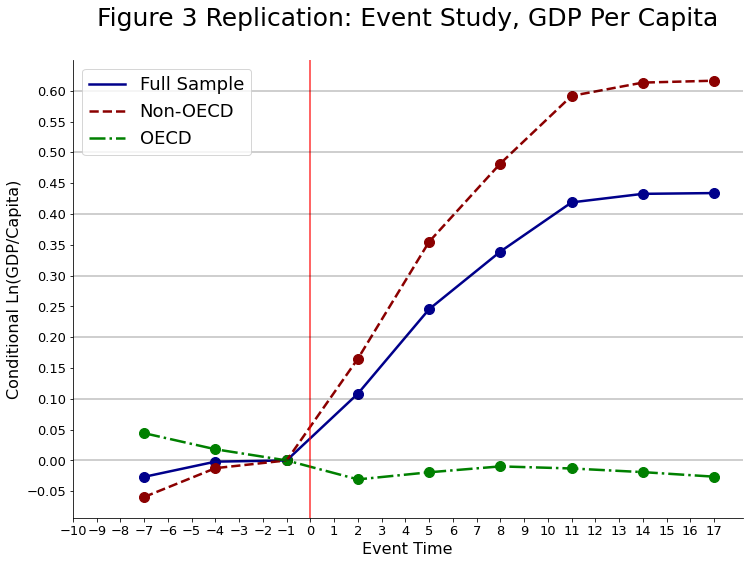

In [10]:
fig,ax = plt.subplots(figsize=(12,8))

# Formatting stuff
plt.subplots_adjust(top=0.92)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Do plotting
formats = [('darkblue','solid','Full Sample'),
           ('darkred','dashed','Non-OECD'),
           ('green','dashdot','OECD')]
for i,fmt in enumerate(formats):
    plot_times = np.arange(-7,18,3)
    plot_betas = list(betas[i][-8:-6])+[0.0]+list(betas[i][-6:])
    plt.scatter(plot_times, plot_betas, color=fmt[0], s=100)
    plt.plot(plot_times, plot_betas, color=fmt[0], 
             linestyle=fmt[1], linewidth=2.5, label=fmt[2])
ax.axvline(x=0, color='red', linestyle='solid', alpha=0.8)
for i in np.arange(0.0,0.7,0.1):
    ax.axhline(y=i, color='black', linestyle='solid', alpha=0.25)

# Axis formatting
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xticks(np.arange(-10,18,1))
ax.set_yticks(np.arange(-0.05,0.65,0.05))
ax.set_xlabel("Event Time", size=16)
ax.set_ylabel("Conditional Ln(GDP/Capita)", size=16)

# More formatting
ax.set_title("Figure 3 Replication: Event Study, GDP Per Capita\n", size=25)
ax.legend(fontsize=18, loc='upper left')

plt.savefig("./q1_output/figure3_replication.png")
plt.show()

# Q1(b) - Replication of Synthetic Control

## Data Prep

In [11]:
# Authors drop these two for some secret reason throughout this analysis
sc_df = df[(df.country != 'Puerto Rico') & (df.country != "Cote d`Ivoire")]
predvars  = ['GDPpc_t1','GDPpc_t3','GDPpc_t5','GDPpc_t7','pop_t1','frag_t1']

In [12]:
def country_data_prep(country, sc_df, predvars):
    
    # Get information about the treated country
    ctycode    = sc_df[sc_df.country == country].countrycode.unique()[0]
    region     = sc_df[sc_df.country == country].region.unique()[0]
    event_year = sc_df[sc_df.country == country].event_year.unique()[0]

    # Make df dropping countries not in region and otherwise treated
    curr_df = sc_df.copy()
    curr_df = curr_df[(curr_df.region == region) & 
                      ((curr_df.treat_dummy == 0) | (curr_df.countrycode == ctycode))]

    # Get a bunch of lagged variables
    t1 = curr_df[curr_df.year == (event_year-1)][['country','GDPpc_Madd','population','fragmentation']] \
                .rename(columns={'GDPpc_Madd':'GDPpc_t1', 'population':'pop_t1', 'fragmentation':'frag_t1'})
    t2 = curr_df[curr_df.year == (event_year-2)][['country','GDPpc_Madd','population','fragmentation']] \
                .rename(columns={'GDPpc_Madd':'GDPpc_t2', 'population':'pop_t2', 'fragmentation':'frag_t2'})
    t3 = curr_df[curr_df.year == (event_year-3)][['country','GDPpc_Madd','population','fragmentation']] \
                .rename(columns={'GDPpc_Madd':'GDPpc_t3', 'population':'pop_t3', 'fragmentation':'frag_t3'})
    t4 = curr_df[curr_df.year == (event_year-4)][['country','GDPpc_Madd','population','fragmentation']] \
                .rename(columns={'GDPpc_Madd':'GDPpc_t4', 'population':'pop_t4', 'fragmentation':'frag_t4'})
    t5 = curr_df[curr_df.year == (event_year-5)][['country','GDPpc_Madd','population','fragmentation']] \
                .rename(columns={'GDPpc_Madd':'GDPpc_t5', 'population':'pop_t5', 'fragmentation':'frag_t5'})
    t6 = curr_df[curr_df.year == (event_year-6)][['country','GDPpc_Madd','population','fragmentation']] \
                .rename(columns={'GDPpc_Madd':'GDPpc_t6', 'population':'pop_t6', 'fragmentation':'frag_t6'})
    t7 = curr_df[curr_df.year == (event_year-7)][['country','GDPpc_Madd','population','fragmentation']] \
                .rename(columns={'GDPpc_Madd':'GDPpc_t7', 'population':'pop_t7', 'fragmentation':'frag_t7'})

    # Merge in variables into main df
    X = t1.copy()
    X = X.merge(t2, on='country', how='inner')
    X = X.merge(t3, on='country', how='inner')
    X = X.merge(t4, on='country', how='inner')
    X = X.merge(t5, on='country', how='inner')
    X = X.merge(t6, on='country', how='inner')
    X = X.merge(t7, on='country', how='inner')

    # Build X1 and X0 matrices
    X1 = X[X.country == country].sort_values(['country'])[predvars].T.to_numpy()
    X0 = X[X.country != country].sort_values(['country'])[predvars].T.to_numpy()
    
    # Build Z1 and Z0 matrices
    Z1 = curr_df[(curr_df.country == country) & (curr_df.year < event_year)].sort_values(['country','year'])
    Z1 = Z1['GDPpc_Madd'].to_numpy()[:,None]
    Z0 = curr_df[(curr_df.country != country) & (curr_df.year < event_year)].sort_values(['country','year'])
    Z0 = Z0[['country','year','GDPpc_Madd']].pivot(index=['year'], columns='country').to_numpy()

    # Build matrices for prediction
    Y1 = curr_df[(curr_df.country == country) & (curr_df.year >= event_year)].sort_values(['country','year'])
    Y1 = Y1['GDPpc_Madd'].to_numpy()[:,None]
    Y0 = curr_df[(curr_df.country != country) & (curr_df.year >= event_year)].sort_values(['country','year'])
    Y0 = Y0[['country','year','GDPpc_Madd']].pivot(index=['year'], columns='country').to_numpy()

    # Get list of donor countries
    donors = X[X.country != country].sort_values(['country'])['country'].unique()
                
    return X1,X0,Z1,Z0,Y1,Y0,donors

## Functions for Getting Synthetic Control

In [13]:
def inner_objective(W, V, X1, X0):
    obj = np.sqrt(((X1 - (X0 @ W[:,None])).T @ V @ (X1 - (X0 @ W[:,None]))))
    jac = ((X1-(X0@W[:,None])).T @ V @ (X1-(X0@W[:,None])))**(-1/2) * (-X0.T @ V @ (X1-(X0@W[:,None])))
    return (obj[0][0], jac.ravel())

def get_optimal_w(V, X1, X0, w_init):
    res = scipy.optimize.minimize(fun    = inner_objective, 
                                  x0     = w_init, 
                                  args   = (V,X1,X0),
                                  method = 'SLSQP',
                                  jac    = True,
                                  bounds = (((0,None),)*X0.shape[1]), 
                                  constraints = [{'type':'eq',
                                                  'fun':lambda w: np.sum(w)-1}])
    return res.x

def outer_objective(V, X1, X0, Z1, Z0, w_init):
    wstar    = get_optimal_w(np.diag(V), X1, X0, w_init)
    obj      = ((Z1 - (Z0 @ wstar[:,None])).T @ (Z1 - (Z0 @ wstar[:,None])))
    return obj[0][0]/100000.

def get_optimal_v(X1, X0, Z1, Z0, w_init, v_init):
    res = scipy.optimize.minimize(fun    = outer_objective, 
                                  x0     = v_init, 
                                  args   = (X1,X0,Z1,Z0,w_init),
                                  method = 'SLSQP',
                                  bounds = (((0,None),)*len(v_init)),
                                  constraints = [{'type':'eq',
                                                  'fun':lambda v: np.sum(v)-1}])
    return np.diag(res.x)

In [14]:
def get_country_sc(country, sc_df, predvars, suffix, optimal_v=True):
    
    # Get matrices for optimization
    X1,X0,Z1,Z0,Y1,Y0,donors = country_data_prep(country, sc_df, predvars)

    # Set initial values for optimization
    np.random.seed(42)
    w_init = np.ones(X0.shape[1])/X0.shape[1]
    v_init = np.random.uniform(size=len(predvars))
    v_init = v_init/np.sum(v_init)

    # Get optimal V and W
    if optimal_v == True:
        V = get_optimal_v(X1, X0, Z1, Z0, w_init, v_init)
    else:
        V = np.eye(len(predvars))
    W = get_optimal_w(V, X1, X0, w_init)

    # Put into dataframe for latex 
    weight_df = pd.DataFrame({'Donors':donors,
                              'Weights':np.round(W,4)})
    weight_df = weight_df[weight_df.Weights > 0.0]
    weight_df.to_latex(f"./q1_output/donors_{country.lower()}_{suffix}.tex", index=False)
    print(f"{country}:\n",weight_df,"\n")

    # Get time series for synthetic and real country
    real_country       = sc_df[(sc_df.country == country)]['GDPpc_Madd']
    synth_country_post = list((Y0 @ W[:,None]).ravel())
    synth_country_pre  = list((Z0 @ W[:,None]).ravel())
    synth_country      = synth_country_pre+synth_country_post
    
    # Make plot for this country
    event_year = sc_df[sc_df.country == country].event_year.unique()[0]
    make_sc_plot(country,real_country,synth_country,event_year,suffix)
    
    return real_country,synth_country

def make_sc_plot(country,real_country,synth_country,event_year,suffix):
    # Formatting stuff
    fig,ax = plt.subplots(figsize=(9,6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Do plotting
    ax.scatter(np.arange(1950, 2009), real_country, s=60)
    ax.scatter(np.arange(1950, 2009), synth_country, s=60)
    ax.plot(np.arange(1950, 2009), real_country, linewidth=2, label=f'Actual {country}')
    ax.plot(np.arange(1950, 2009), synth_country, linewidth=2, label=f'Synthetic {country}')
    ax.axvline(x=event_year, color='red', linestyle='solid', alpha=0.8)

    # Axis formatting
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_xticks(np.arange(1950,2011,5))
    ax.set_xlabel("Year", size=16)
    ax.set_ylabel("GDP/Capita", size=16)

    # More formatting
    ax.set_title(f"Synthetic Control Replication: {country}", size=20)
    ax.legend(fontsize=14)

    plt.savefig(f"./q1_output/synth_{country.lower()}_{suffix}.png")
    plt.show()

## Get Synthetic Controls and Plots - Optimized V

Algeria:
     Donors  Weights
1    Egypt   0.3923
2   Israel   0.0725
3   Jordan   0.3565
6  Tunisia   0.1787 



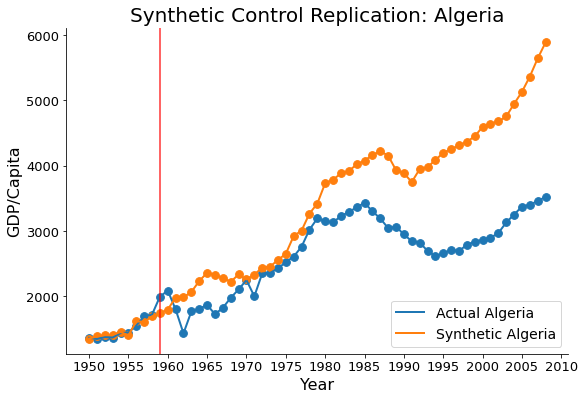

Botswana:
        Donors  Weights
2     Burundi   0.1113
4  Cape Verde   0.8887 



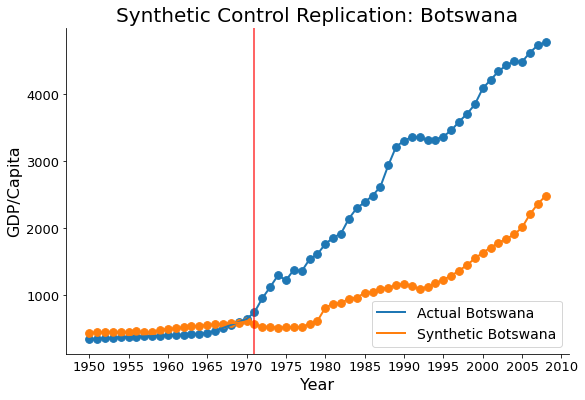

Congo, Republic of:
         Donors  Weights
12     Liberia   0.7191
18  Mozambique   0.0128
19     Namibia   0.0829
25   Swaziland   0.1851 



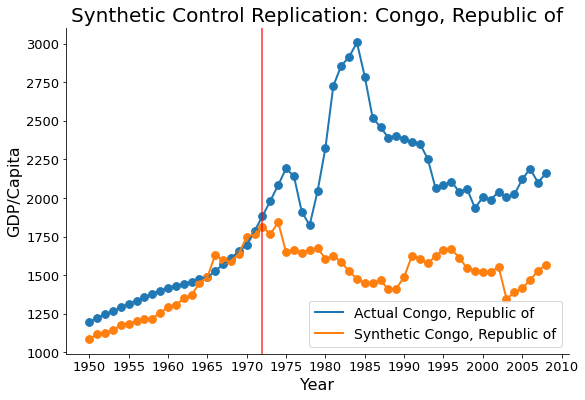

Libya:
    Donors  Weights
1   Egypt   0.7423
3  Jordan   0.2578 



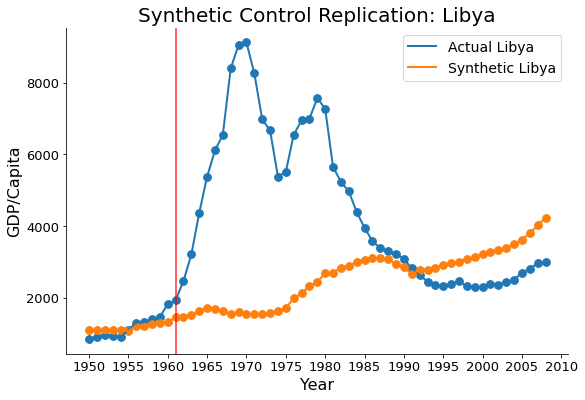

Netherlands:
         Donors  Weights
0      Belgium   0.6708
3      Germany   0.0533
5       Sweden   0.1578
6  Switzerland   0.1181 



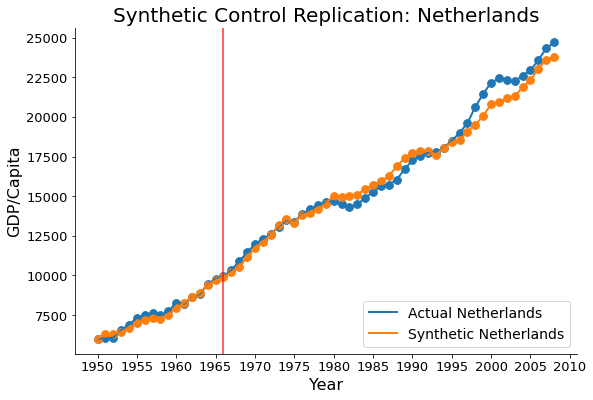

In [15]:
# Loop over all countries
predvars    = ['GDPpc_t1','GDPpc_t3','GDPpc_t5','GDPpc_t7','pop_t1','frag_t1']
countries   = ['Algeria','Botswana','Congo, Republic of','Libya','Netherlands']
logdiffs    = []
event_times = []
for country in countries:
    
    # Get real and synthetic control version of that country
    real_country,synth_country = get_country_sc(country, sc_df, predvars, "main", optimal_v=True)
    
    # Get time series for plots
    logdiff  = np.log(real_country)-np.log(synth_country)
    event_tm = sc_df[sc_df.country==country].event_time
    logdiffs.append(logdiff)
    event_times.append(event_tm)

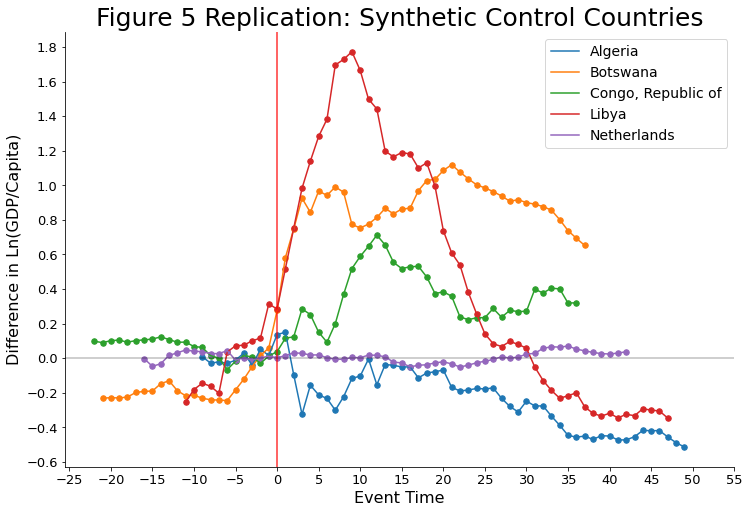

In [16]:
# Formatting stuff
fig,ax = plt.subplots(figsize=(12,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Do plotting
for i in range(len(logdiffs)):
    ax.scatter(event_times[i], logdiffs[i], s=30)
    ax.plot(event_times[i], logdiffs[i], label=countries[i])
ax.axvline(x=0, color='red', linestyle='solid', alpha=0.8)
ax.axhline(y=0, color='black', linestyle='solid', alpha=0.25)

# Axis formatting
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xticks(np.arange(-25,60,5))
ax.set_yticks(np.arange(-0.6,1.9,0.2))
ax.set_xlabel("Event Time", size=16)
ax.set_ylabel("Difference in Ln(GDP/Capita)", size=16)

# More formatting
ax.set_title("Figure 5 Replication: Synthetic Control Countries", size=25)
ax.legend(fontsize=14)

plt.savefig(f"./q1_output/figure5_replication.png")
plt.show()

## Synthetic Controls and Plots - Identity V

Algeria:
     Donors  Weights
1    Egypt   0.3597
2   Israel   0.0574
3   Jordan   0.3652
6  Tunisia   0.2176 



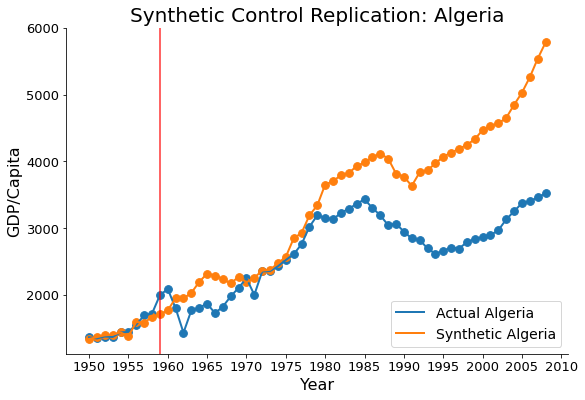

Botswana:
        Donors  Weights
2     Burundi   0.1001
4  Cape Verde   0.8999 



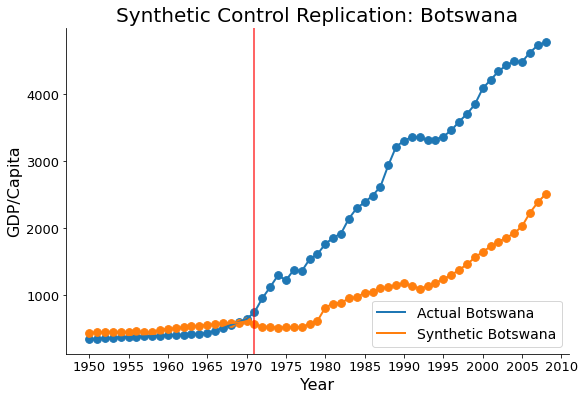

Congo, Republic of:
         Donors  Weights
12     Liberia   0.6791
18  Mozambique   0.0171
19     Namibia   0.0762
25   Swaziland   0.2276 



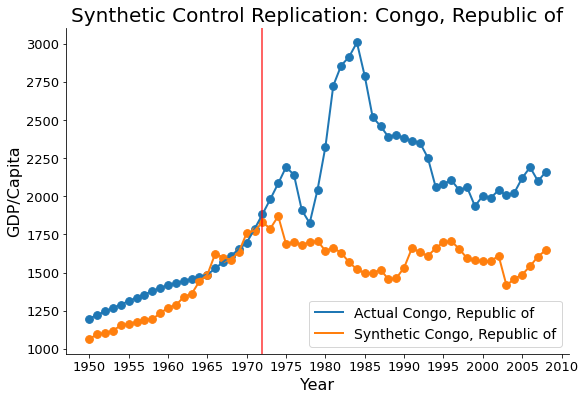

Libya:
      Donors  Weights
0  Djibouti   0.6744
6   Tunisia   0.3256 



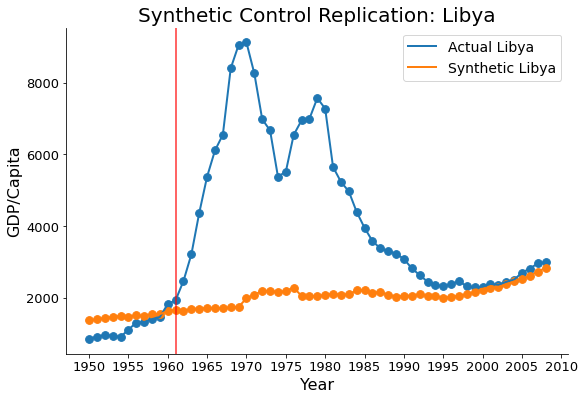

Netherlands:
         Donors  Weights
0      Belgium   0.6203
3      Germany   0.0540
5       Sweden   0.2286
6  Switzerland   0.0971 



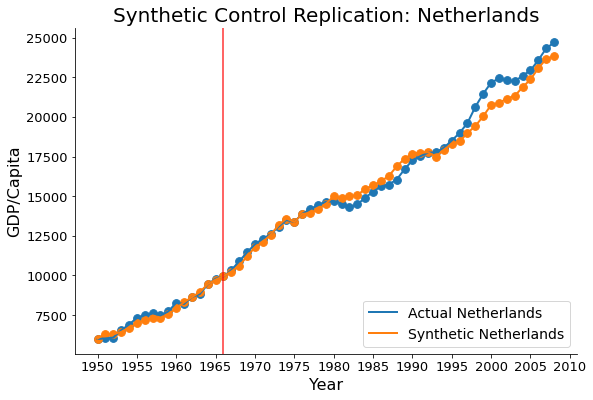

In [17]:
# Loop over all countries
predvars    = ['GDPpc_t1','GDPpc_t3','GDPpc_t5','GDPpc_t7','pop_t1','frag_t1']
countries   = ['Algeria','Botswana','Congo, Republic of','Libya','Netherlands']
logdiffs    = []
event_times = []
for country in countries:
    
    # Get real and synthetic control version of that country
    real_country,synth_country = get_country_sc(country, sc_df, predvars, "identityV", optimal_v=False)
    
    # Get time series for plots
    logdiff  = np.log(real_country)-np.log(synth_country)
    event_tm = sc_df[sc_df.country==country].event_time
    logdiffs.append(logdiff)
    event_times.append(event_tm)

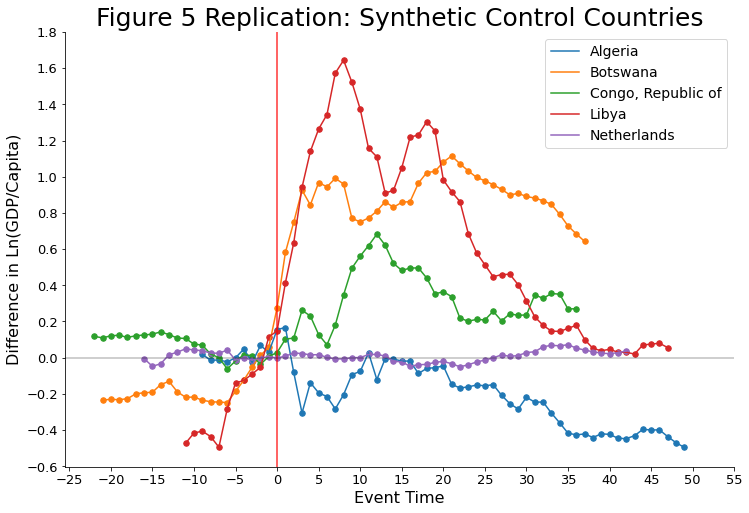

In [18]:
# Formatting stuff
fig,ax = plt.subplots(figsize=(12,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Do plotting
for i in range(len(logdiffs)):
    ax.scatter(event_times[i], logdiffs[i], s=30)
    ax.plot(event_times[i], logdiffs[i], label=countries[i])
ax.axvline(x=0, color='red', linestyle='solid', alpha=0.8)
ax.axhline(y=0, color='black', linestyle='solid', alpha=0.25)

# Axis formatting
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xticks(np.arange(-25,60,5))
ax.set_yticks(np.arange(-0.6,1.9,0.2))
ax.set_xlabel("Event Time", size=16)
ax.set_ylabel("Difference in Ln(GDP/Capita)", size=16)

# More formatting
ax.set_title("Figure 5 Replication: Synthetic Control Countries", size=25)
ax.legend(fontsize=14)

plt.savefig(f"./q1_output/figure5_replication_identity.png")
plt.show()

# Q1(c) - Test Alternate Covariates

## Function for Plotting Figure 5 Alternate

In [19]:
def plot_fig5_alt(event_times, logdiffs, countries, suffixnum):
    
    # Formatting stuff
    fig,ax = plt.subplots(figsize=(12,8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Do plotting
    for i in range(len(logdiffs)):
        ax.scatter(event_times[i], logdiffs[i], s=30)
        ax.plot(event_times[i], logdiffs[i], label=countries[i])
    ax.axvline(x=0, color='red', linestyle='solid', alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='solid', alpha=0.25)

    # Axis formatting
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_xticks(np.arange(-25,60,5))
    ax.set_yticks(np.arange(-0.6,1.9,0.2))
    ax.set_xlabel("Event Time", size=16)
    ax.set_ylabel("Difference in Ln(GDP/Capita)", size=16)

    # More formatting
    ax.set_title(f"Figure 5 Alternate Covariates Spec. {suffixnum}", size=25)
    ax.legend(fontsize=14)

    plt.savefig(f"./q1_output/figure5_alt{suffixnum}.png")
    plt.show()

## Alternate 1 - Remove Population and Fragmentation

Algeria:
    Donors  Weights
1   Egypt   0.7130
2  Israel   0.1904
3  Jordan   0.0966 



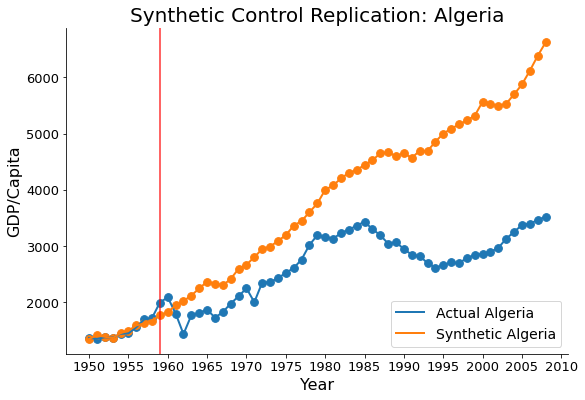

Botswana:
      Donors  Weights
2   Burundi   0.3718
14   Malawi   0.1077
21   Rwanda   0.5204 



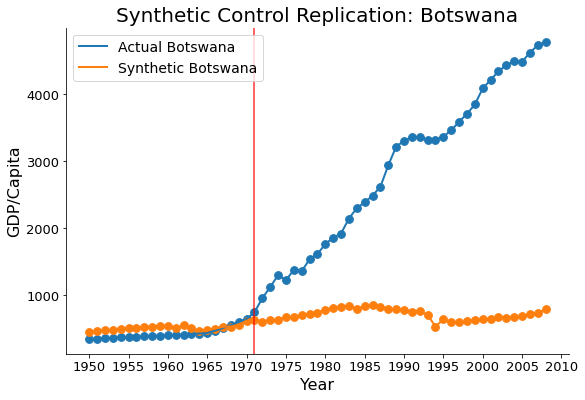

Congo, Republic of:
                       Donors  Weights
0                      Benin   0.0002
2                    Burundi   0.0024
4                 Cape Verde   0.0004
5   Central African Republic   0.0006
6                       Chad   0.0042
7                Gambia, The   0.0047
8                      Ghana   0.0049
9                     Guinea   0.0018
10                     Kenya   0.0006
11                   Lesotho   0.0003
12                   Liberia   0.2506
13                Madagascar   0.0001
14                    Malawi   0.0001
15                      Mali   0.0008
16                Mauritania   0.0002
17                 Mauritius   0.0390
18                Mozambique   0.3731
19                   Namibia   0.0479
20                     Niger   0.0050
22                   Senegal   0.0031
23                   Somalia   0.0879
24                     Sudan   0.0024
25                 Swaziland   0.1391
27                      Togo   0.0027
28                    Uganda 

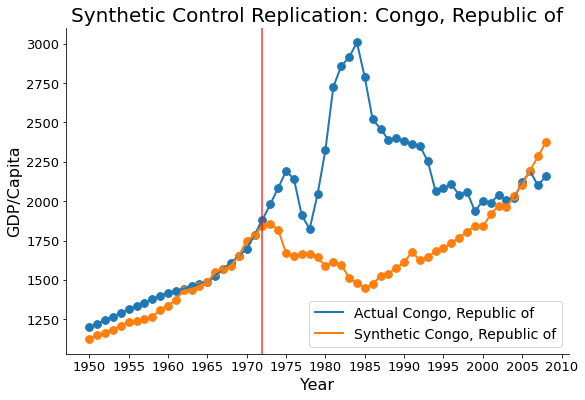

Libya:
    Donors  Weights
1   Egypt   0.8484
2  Israel   0.1516 



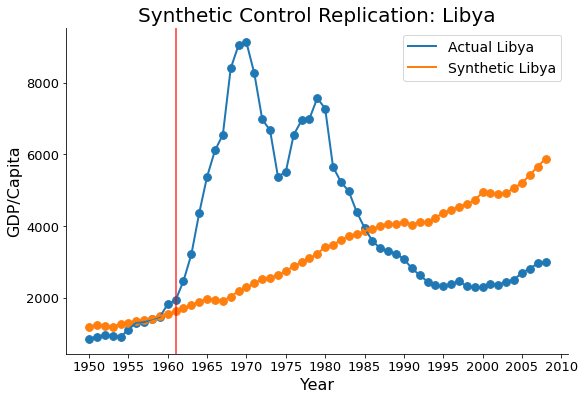

Netherlands:
         Donors  Weights
0      Belgium   0.2910
3      Germany   0.3953
5       Sweden   0.2666
6  Switzerland   0.0471 



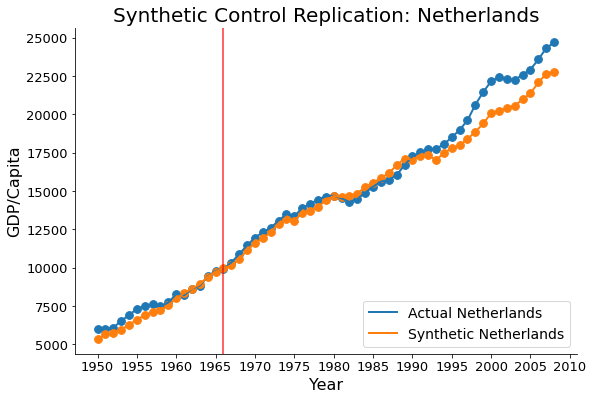

In [20]:
# Loop over all countries
predvars    = ['GDPpc_t1','GDPpc_t3','GDPpc_t5','GDPpc_t7']
countries   = ['Algeria','Botswana','Congo, Republic of','Libya','Netherlands']
logdiffs    = []
event_times = []
for country in countries:
    
    # Get real and synthetic control version of that country
    real_country,synth_country = get_country_sc(country, sc_df, predvars, "alt1", optimal_v=False)
    
    # Get time series for plots
    logdiff  = np.log(real_country)-np.log(synth_country)
    event_tm = sc_df[sc_df.country==country].event_time
    logdiffs.append(logdiff)
    event_times.append(event_tm)

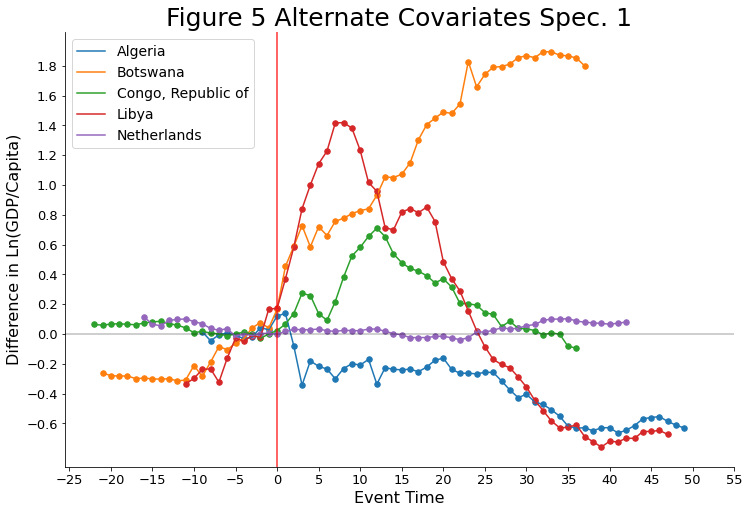

In [21]:
plot_fig5_alt(event_times, logdiffs, countries, 1)

## Alternate 2 - Add in Extra Years for Covariates

Algeria:
     Donors  Weights
1    Egypt   0.3370
2   Israel   0.1286
3   Jordan   0.1472
6  Tunisia   0.3872 



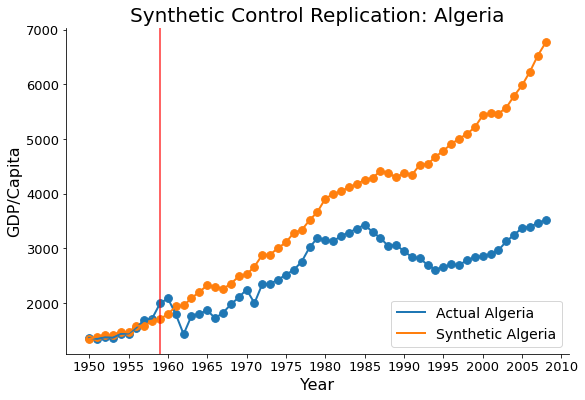

Botswana:
        Donors  Weights
2     Burundi   0.1012
4  Cape Verde   0.8988 



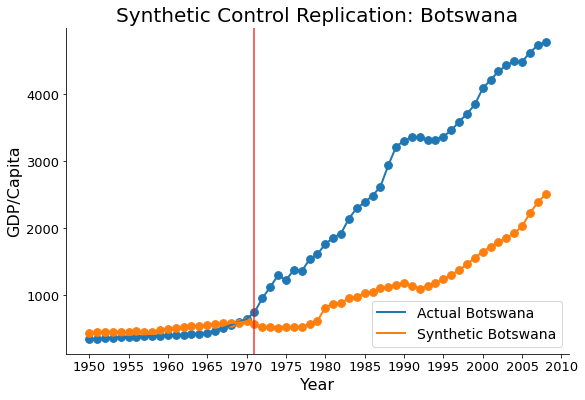

Congo, Republic of:
         Donors  Weights
12     Liberia   0.5667
16  Mauritania   0.0413
17   Mauritius   0.1068
18  Mozambique   0.0148
25   Swaziland   0.2139
27        Togo   0.0564 



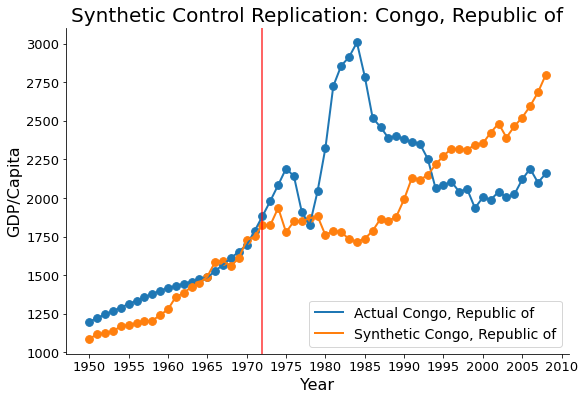

Libya:
      Donors  Weights
0  Djibouti   0.7021
6   Tunisia   0.2979 



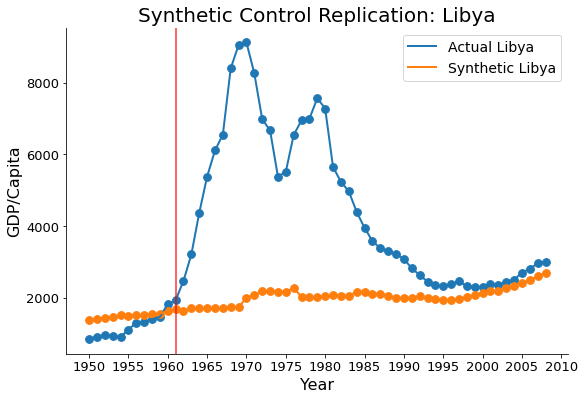

Netherlands:
         Donors  Weights
0      Belgium   0.3603
2       France   0.1235
4      Ireland   0.1843
5       Sweden   0.0820
6  Switzerland   0.2498 



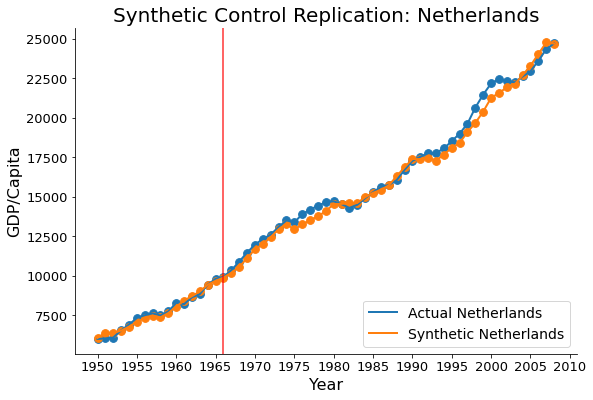

In [22]:
# Loop over all countries
predvars    = ['GDPpc_t1','GDPpc_t2','GDPpc_t3','GDPpc_t4','GDPpc_t5','GDPpc_t6','GDPpc_t7',
               'pop_t1','pop_t2','pop_t3','pop_t4','pop_t5','pop_t6','pop_t7',
               'frag_t1']
countries   = ['Algeria','Botswana','Congo, Republic of','Libya','Netherlands']
logdiffs    = []
event_times = []
for country in countries:
    
    # Get real and synthetic control version of that country
    real_country,synth_country = get_country_sc(country, sc_df, predvars, "alt2", optimal_v=False)
    
    # Get time series for plots
    logdiff  = np.log(real_country)-np.log(synth_country)
    event_tm = sc_df[sc_df.country==country].event_time
    logdiffs.append(logdiff)
    event_times.append(event_tm)

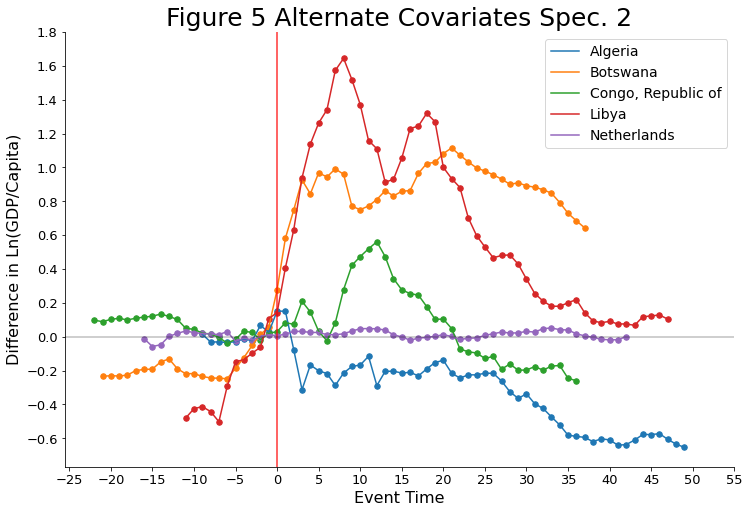

In [23]:
plot_fig5_alt(event_times, logdiffs, countries, 2)

# 1(e) - Nonstationary Residuals Monte Carlo

In [ ]:
def gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale):
    
    # Set seed
    np.random.seed(5882300)

    # Combine countries into dataset 
    ids    = np.tile(np.arange(1,N+1),T)
    time   = np.repeat(np.arange(1,T+1),N)
    cdf    = pd.DataFrame({'id':np.arange(1,N+1),'cohort':cohorts})
    df     = pd.DataFrame({'id':ids,'time':time})
    df     = df.merge(cdf, on='id', how='inner')

    # Add relative time and treatment indicator
    df['rel'] = df.time - df.cohort
    df['rel'] = np.where(df.cohort > T, -np.inf, df.rel)
    df['D']   = (df.rel >= 0).astype(int)

    # Add random person fixed effects and linear time trend.
    i_fe    = np.random.uniform(size=N) * i_fe_scale
    t_fe    = t_fe_trend + np.random.normal(loc=0.0,scale=t_fe_scale,size=T)
    i_fe_df = pd.DataFrame({'id':np.arange(1,N+1),'i_fe':i_fe})
    t_fe_df = pd.DataFrame({'time':np.arange(1,T+1),'t_fe':t_fe})
    df      = df.merge(i_fe_df, on='id', how='inner')
    df      = df.merge(t_fe_df, on='time', how='inner')

    # Random noise
    df['u0'] = np.random.normal(size=N*T, loc=0.0, scale=u0_scale)
    df['u1'] = np.random.normal(size=N*T, loc=0.0, scale=u1_scale)

    # Potential outcomes model
    df        = df.sort_values(['id','time'])
    df['att'] = effects
    df['y0']  = baseline + df.t_fe + df.i_fe + df.u0
    df['y1']  = baseline + df.t_fe + df.i_fe + df.att + df.u1
    df['y']   = df.D*(df.y1) + (1.0-df.D)*(df.y0)

    # Average by cohort
    agg_df = df.groupby(['cohort','time']).mean().reset_index()
    
    return df, agg_df

In [ ]:
# DGP parameters
N          = 100  # Sample size
T          = 60   # Time periods
i_fe_scale = 8.0  # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 0.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 0.0  # Variance of noise term added to Y(0)
u1_scale   = 0.0  # Variance of noise term added to Y(1)
baseline   = 5.0  # Baseline level of potential outcome

# How things change over time
t_fe_trend = np.arange(1,T+1)-5

# Cohorts
cohorts = np.array([10, 50])

# Treatment effects
effects = np.repeat(3.0, N*T)

# Get data 
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)
